In [1]:
import ROOT
import os, sys

Welcome to JupyROOT 6.26/10


In [2]:
campaign = '2018_UL_2L'
filelist = os.listdir(f'inputs/{campaign}')
filelist = [item for item in filelist if item.endswith("root")] #Keeping only the file that end with 'root'
outdir = f'plots/{campaign}/'
os.system(f'mkdir -p {outdir}')
print('files read.')

files read.


In [3]:
def calculate_eff(num, den, bin_x, bin_y, type):
    num_val = num.GetBinContent(bin_x, bin_y)
    den_val = den.GetBinContent(bin_x, bin_y)
    num_err = num.GetBinError(bin_x, bin_y)
    den_err = den.GetBinError(bin_x, bin_y)
    if num_val == 0 or den_val == 0:
        #Return default values:
        if 'bJet' in type: return 1.0, 0.0
        else:              return 0.0, 0.0
    eff = num_val / den_val
    eff_err = eff * ROOT.TMath.Sqrt((num_err / num_val)**2 + (den_err / den_val)**2)
    return eff, eff_err
print('Efficiency function loaded.')

Efficiency function loaded.


### Producing the efficiency maps from each sample and storing the numbers in a dictionary

In [4]:
def produce_eff_dict(type):
    eff_dict = {}
    
    for file in filelist:   
        sample = file.split('_')[1]
        subsample = file.split('_')[2].split('.')[0]
        #Correcting for QCD and VLLs
        if 'QCD' in file or 'VLL' in file or 'SingleTop' in file: #Taking care of the extra _
            sample = file.split('_')[1]+'_'+file.split('_')[2]
            subsample = file.split('_')[3].split('.')[0]
        if subsample == 'tZq': subsample = 'tZq_ll'
        #print(sample, subsample)
        #continue
    
        #print(f'Producing the scale factors for {sample} {subsample}')
        eff_dict[sample+"_"+subsample] = {}
    
        #Reading the file as TFile and extracting the 2D histograms:
        filepath = f'inputs/{campaign}/{file}'
        tfile = ROOT.TFile.Open(filepath, 'READ')
    
        if type == 'bJetTagEff':
            num = 'bJet_MedWP_PtEta'
            den = 'bJet_PtEta'
        elif type == 'cJetMisEff':
            num = 'cJet_Mis_PtEta' 
            den = 'cJet_PtEta'
        elif type == 'lightJetMisEff':
            num = 'LightJet_Mis_PtEta' 
            den = 'LightJet_PtEta'
    
        hst_num = tfile.Get(num)
        hst_den = tfile.Get(den)
    
        #Producing the efficiency histogram:
        hst_eff=hst_num.Clone()
        hst_eff.Divide(hst_den)

        bin = 0
        for y in range(1, 4):
            eff_dict[sample+"_"+subsample][f'etabin_{y}'] = {}
            for x in range(2, 11):
                bin=bin+1
                eff_dict[sample+"_"+subsample][f'etabin_{y}'][f'ptbin_{x}'] = {}
                #eff = hst_eff.GetBinContent(x, y)
                numerator   = hst_num.GetBinContent(x, y)
                denominator = hst_den.GetBinContent(x, y)
                eff, efferr = calculate_eff(hst_num, hst_den, x, y, type)
                #hst_eff.SetBinError(x, y, efferr)
                eff_dict[sample+"_"+subsample][f'etabin_{y}'][f'ptbin_{x}']['num'] = numerator
                eff_dict[sample+"_"+subsample][f'etabin_{y}'][f'ptbin_{x}']['den'] = denominator
                eff_dict[sample+"_"+subsample][f'etabin_{y}'][f'ptbin_{x}']['eff'] = eff
                eff_dict[sample+"_"+subsample][f'etabin_{y}'][f'ptbin_{x}']['efferr'] = efferr
                #print(x, y, eff)
            
        #Making a plot for the efficieency bins
        canvas=ROOT.TCanvas('effmap_'+type+'_'+sample+'_'+subsample, "", 800, 600)
        ROOT.gStyle.SetOptStat(0)
    
        #Decorating the hist
        hst_eff.SetTitle(type+' for '+sample+' '+subsample)
        hst_eff.SetTitleSize(1)
        hst_eff.SetTitleOffset(0.8)
        hst_eff.Draw('colz text same')
        hst_eff.GetZaxis().SetRangeUser(0.0,1.0)
        hst_eff.GetYaxis().SetTitle("|#eta|")
        hst_eff.GetYaxis().SetTitleSize(0.05)
        hst_eff.GetYaxis().SetTitleOffset(0.8)
        hst_eff.GetYaxis().SetLabelSize(0.03)
        hst_eff.GetXaxis().SetTitle("p_{T}   ") 
        hst_eff.GetXaxis().SetTitleSize(0.05)
        hst_eff.GetXaxis().SetTitleOffset(0.8)
        hst_eff.GetXaxis().SetLabelSize(0.03)
        #Decorating the canvas
        canvas.SetLogx(1)
        ROOT.gStyle.SetPaintTextFormat(".2f");
        canvas.Draw()
        os.system(f'mkdir -p {outdir}/{type}')
        #print(f'{outdir}{type}/{type}_{sample}_{subsample}.png')
        canvas.SaveAs(f'{outdir}{type}/{den}_{sample}_{subsample}.png')
        #print(f'nbins = {bin}')
        #break

    return eff_dict
print('Ready to produce dictionaries.')

Ready to produce dictionaries.


In [5]:
print('Hold on ...')
eff_dict_bTag = produce_eff_dict('bJetTagEff')
eff_dict_cMis = produce_eff_dict('cJetMisEff')
eff_dict_lMis = produce_eff_dict('lightJetMisEff')
print('Done!')

Hold on ...
Done!


Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_DYJetsToLL_M10to50.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_DYJetsToLL_M50.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_100to200.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_1200to2500.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_200to400.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_2500toInf.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_400to600.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJet_PtEta_HTbinnedWJets_600to800.png has been created
Info in <TCanvas::Print>: png file plots/2018_UL_2L/bJetTagEff/bJ

In [6]:
print(eff_dict_bTag)

{'DYJetsToLL_M10to50': {'etabin_1': {'ptbin_2': {'num': 159.0, 'den': 205.0, 'eff': 0.775609756097561, 'efferr': 0.08196311632862016}, 'ptbin_3': {'num': 95.0, 'den': 115.0, 'eff': 0.8260869565217391, 'efferr': 0.11453143165532403}, 'ptbin_4': {'num': 72.0, 'den': 79.0, 'eff': 0.9113924050632911, 'efferr': 0.14849577077344409}, 'ptbin_5': {'num': 25.0, 'den': 28.0, 'eff': 0.8928571428571429, 'efferr': 0.2456806158706406}, 'ptbin_6': {'num': 8.0, 'den': 10.0, 'eff': 0.8, 'efferr': 0.37947331922020555}, 'ptbin_7': {'num': 3.0, 'den': 3.0, 'eff': 1.0, 'efferr': 0.816496580927726}, 'ptbin_8': {'num': 2.0, 'den': 3.0, 'eff': 0.6666666666666666, 'efferr': 0.6085806194501846}, 'ptbin_9': {'num': 0.0, 'den': 0.0, 'eff': 1.0, 'efferr': 0.0}, 'ptbin_10': {'num': 0.0, 'den': 0.0, 'eff': 1.0, 'efferr': 0.0}}, 'etabin_2': {'ptbin_2': {'num': 142.0, 'den': 181.0, 'eff': 0.7845303867403315, 'efferr': 0.08794832468382825}, 'ptbin_3': {'num': 78.0, 'den': 88.0, 'eff': 0.8863636363636364, 'efferr': 0.13

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the ptbin_map and etabin_map
ptbin_map = {
    "ptbin_2": (20, 30),
    "ptbin_3": (30, 50),
    "ptbin_4": (50, 70),
    "ptbin_5": (70, 100),
    "ptbin_6": (100, 140),
    "ptbin_7": (140, 200),
    "ptbin_8": (200, 300),
    "ptbin_9": (300, 600),
    "ptbin_10": (600, 1000)
}

etabin_map = {
    "etabin_1": (0.0, 0.8),
    "etabin_2": (0.8, 1.6),
    "etabin_3": (1.6, 3.0)
}

print('Settings loaded.')

Settings loaded.


In [8]:
eff_dict_bTag

{'DYJetsToLL_M10to50': {'etabin_1': {'ptbin_2': {'num': 159.0,
    'den': 205.0,
    'eff': 0.775609756097561,
    'efferr': 0.08196311632862016},
   'ptbin_3': {'num': 95.0,
    'den': 115.0,
    'eff': 0.8260869565217391,
    'efferr': 0.11453143165532403},
   'ptbin_4': {'num': 72.0,
    'den': 79.0,
    'eff': 0.9113924050632911,
    'efferr': 0.14849577077344409},
   'ptbin_5': {'num': 25.0,
    'den': 28.0,
    'eff': 0.8928571428571429,
    'efferr': 0.2456806158706406},
   'ptbin_6': {'num': 8.0,
    'den': 10.0,
    'eff': 0.8,
    'efferr': 0.37947331922020555},
   'ptbin_7': {'num': 3.0,
    'den': 3.0,
    'eff': 1.0,
    'efferr': 0.816496580927726},
   'ptbin_8': {'num': 2.0,
    'den': 3.0,
    'eff': 0.6666666666666666,
    'efferr': 0.6085806194501846},
   'ptbin_9': {'num': 0.0, 'den': 0.0, 'eff': 1.0, 'efferr': 0.0},
   'ptbin_10': {'num': 0.0, 'den': 0.0, 'eff': 1.0, 'efferr': 0.0}},
  'etabin_2': {'ptbin_2': {'num': 142.0,
    'den': 181.0,
    'eff': 0.78453038674

In [9]:
eff_dict_cMis

{'DYJetsToLL_M10to50': {'etabin_1': {'ptbin_2': {'num': 253.0,
    'den': 1355.0,
    'eff': 0.18671586715867158,
    'efferr': 0.01278775596952617},
   'ptbin_3': {'num': 102.0,
    'den': 615.0,
    'eff': 0.16585365853658537,
    'efferr': 0.017731561800376702},
   'ptbin_4': {'num': 78.0,
    'den': 416.0,
    'eff': 0.1875,
    'efferr': 0.023135067974663654},
   'ptbin_5': {'num': 19.0,
    'den': 146.0,
    'eff': 0.13013698630136986,
    'efferr': 0.03173872591388634},
   'ptbin_6': {'num': 9.0,
    'den': 71.0,
    'eff': 0.1267605633802817,
    'efferr': 0.044851681050783826},
   'ptbin_7': {'num': 5.0,
    'den': 25.0,
    'eff': 0.2,
    'efferr': 0.09797958971132714},
   'ptbin_8': {'num': 1.0,
    'den': 9.0,
    'eff': 0.1111111111111111,
    'efferr': 0.11712139482105109},
   'ptbin_9': {'num': 0.0, 'den': 0.0, 'eff': 0.0, 'efferr': 0.0},
   'ptbin_10': {'num': 0.0, 'den': 0.0, 'eff': 0.0, 'efferr': 0.0}},
  'etabin_2': {'ptbin_2': {'num': 188.0,
    'den': 1016.0,
    

In [10]:
def make_1d_plot(eff_dict, samplenames, title_):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for ax, (etabin, etarange) in zip(axes, etabin_map.items()):
        for samplename in samplenames:
            
            if samplename not in eff_dict: continue
            bindict = eff_dict[samplename]
            if etabin not in bindict: continue
            valuedict = bindict[etabin]

            x_values = []
            y_values = []
            x_errors = []
            y_errors = []

            for ptbin, value in sorted(valuedict.items()):
                ptrange = ptbin_map[ptbin]
                pt_center = (ptrange[0] + ptrange[1]) / 2
                x_values.append(pt_center)
                y_values.append(value["eff"])
                x_errors.append((pt_center - ptrange[0], ptrange[1] - pt_center))
                y_errors.append(value["efferr"])  # Fixed y error
                
            ax.errorbar(x_values, y_values, xerr=np.array(x_errors).T, yerr=y_errors, label=samplename, fmt='o', capsize=5)

        #Decorations
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.grid(True, linestyle='--', linewidth=1, alpha=0.5)
        ax.tick_params(axis='both', which='both', labelsize=14)
        
        #Labels
        ax.axhline(y=1, color='r', linestyle='--', linewidth=1)
        ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
        ax.set_xlim(0, 1000)
        ax.set_ylim(-0.2, 1.2)
        ax.set_title(f"$|\eta|\in$ {etarange}", fontsize=18)
        ax.set_xlabel('$p_T$', fontsize=18,  horizontalalignment='right', x=1.0)
        ax.set_ylabel('Efficiency', fontsize=18)
        location = 'upper right'
        if 'bJet' in title_: location = 'lower left'
        else: location = 'upper left'
        ax.legend(title=title_, fontsize=12, title_fontsize=14, loc=location, framealpha=1.0)
        

    #fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.savefig(f'plots/{title_}.png', dpi=72)
    plt.show()

print('1D plotmaker ready.')

1D plotmaker ready.


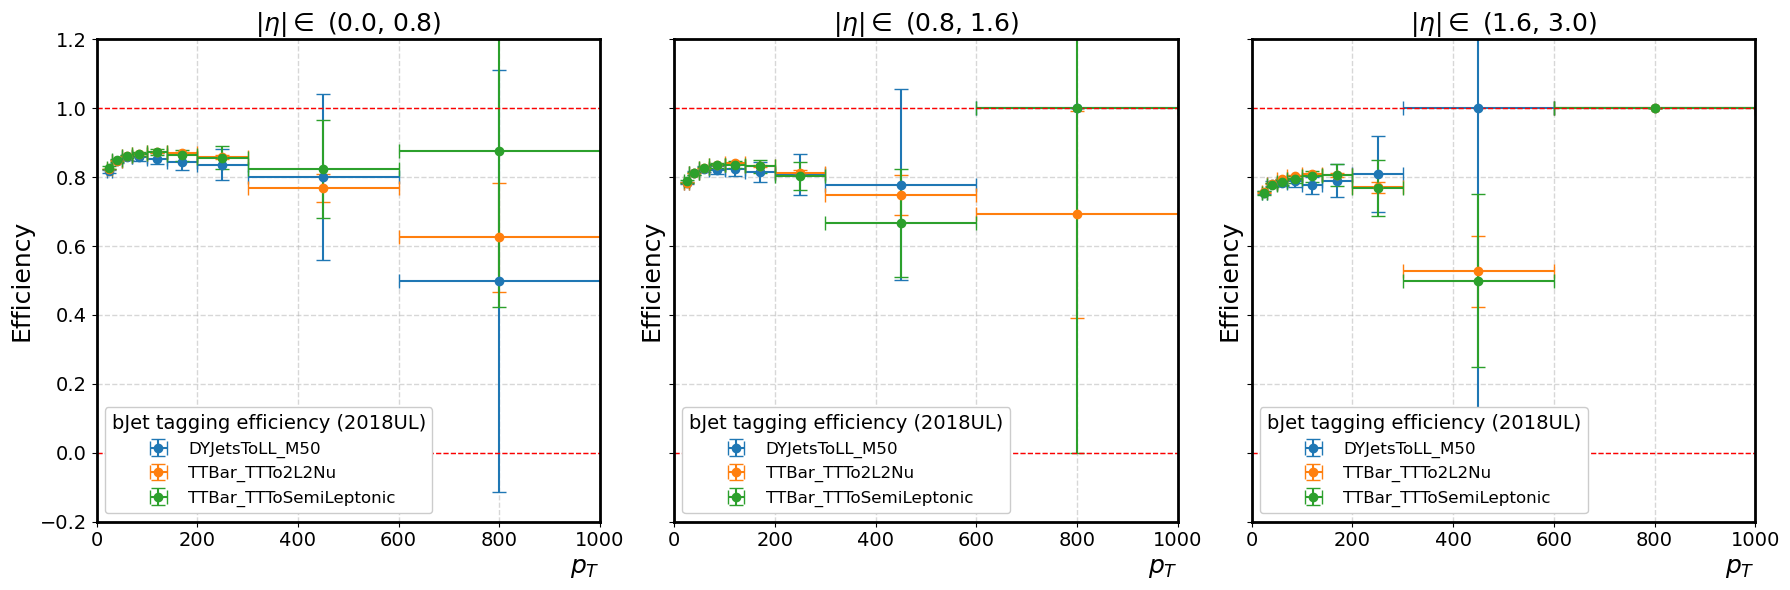

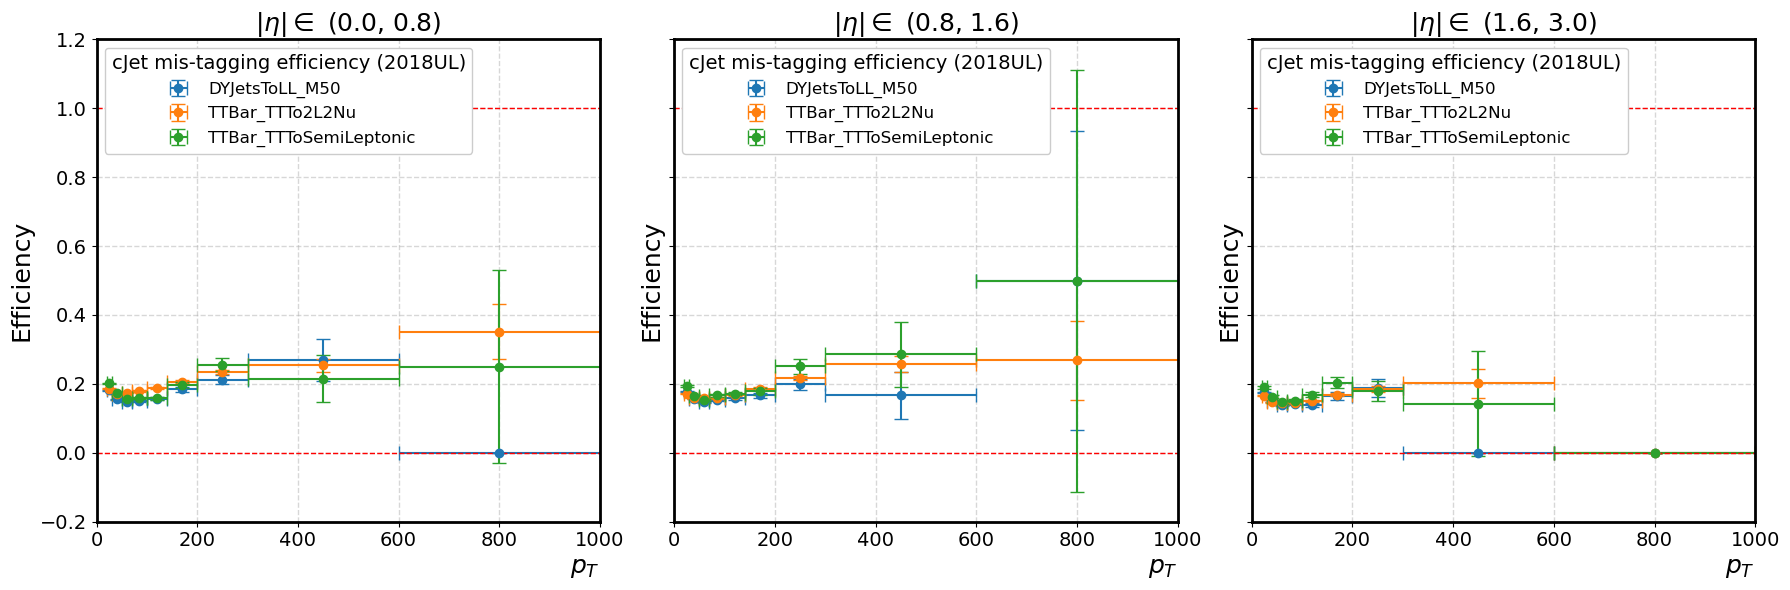

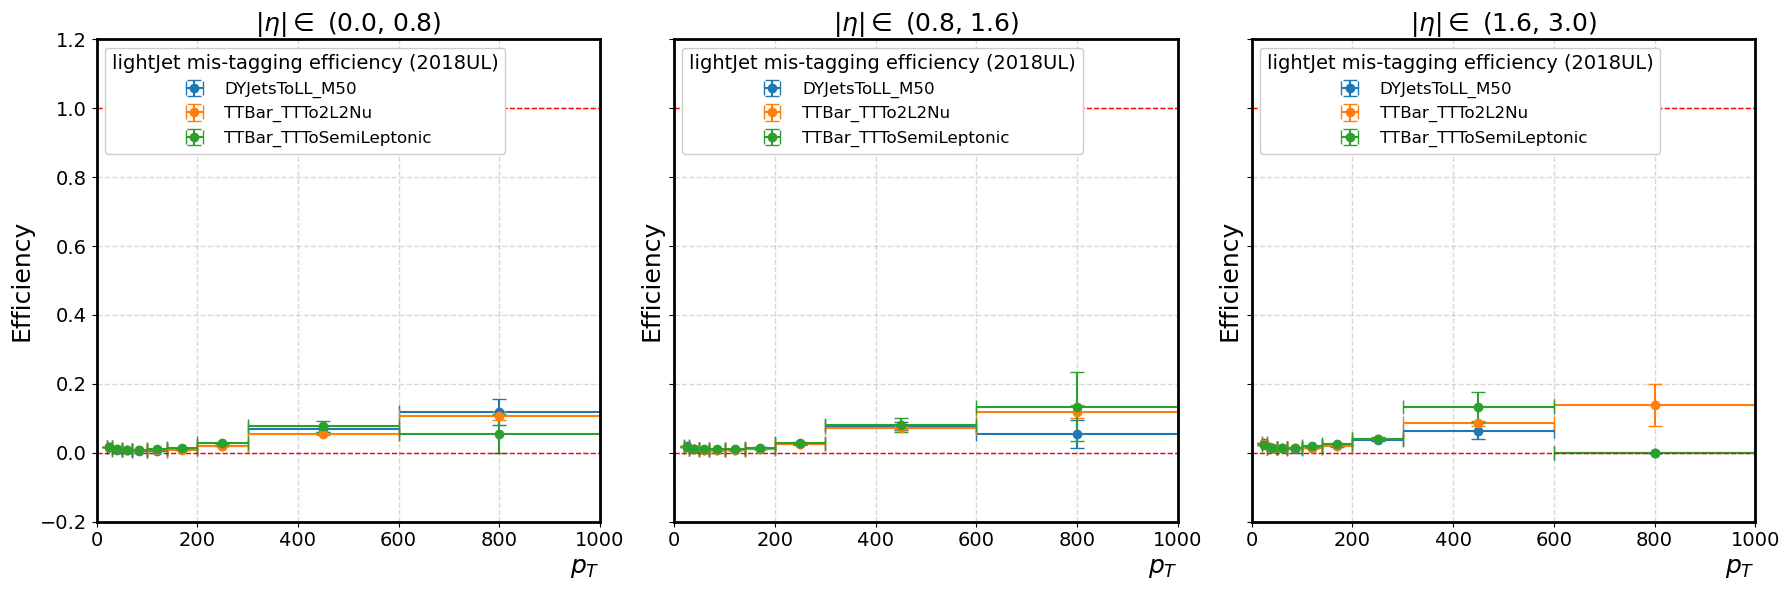

In [11]:
samplenames = ["DYJetsToLL_M50", "TTBar_TTTo2L2Nu", "TTBar_TTToSemiLeptonic"]
make_1d_plot(eff_dict_bTag, samplenames, 'bJet tagging efficiency (2018UL)')
make_1d_plot(eff_dict_cMis, samplenames, 'cJet mis-tagging efficiency (2018UL)')
make_1d_plot(eff_dict_lMis, samplenames, 'lightJet mis-tagging efficiency (2018UL)')

### Reading from the dictinory and prining/saving the numbers (simple text files)

In [12]:
def generate_texts(type):
    eff_dict = None
    if type == 'bJetTagEff' :       eff_dict = eff_dict_bTag
    elif type == 'cJetMisEff' :     eff_dict = eff_dict_cMis
    elif type == 'lightJetMisEff' : eff_dict = eff_dict_lMis
    
    lines_of_texts = [f'{type} summary for {campaign}', '']
    for sample, bindict in eff_dict.items():
        #print(f'//For the sample {sample}:')
        lines_of_texts += [f"{sample}", ' ']

        list_etabins = []
        for etabins, valuedict in sorted(bindict.items()):
            #print(etabins)
            list_ptbins = []
            for ptbins, value in sorted(valuedict.items()):
                #print(ptbins, value['eff'])
                list_ptbins.append(value['eff'])
            list_etabins.append(list_ptbins)

    list_str = str(list_etabins)
    list_str = list_str.replace('[', '{').replace(']', '}')
    lines_of_texts+=([list_str, ''])
    #print(list_str)
    print('Done')
    return list_str

print('Function ready.')

Function ready.


In [13]:
txt_bTag = generate_texts('bJetTagEff')
txt_cMis = generate_texts('cJetMisEff')
txt_lMis = generate_texts('lightJetMisEff')

Done
Done
Done


In [14]:
def save_text_file(type):
    with open(f"text_files/{campaign}_{type}.txt", "w") as file:
    # Iterate over each line in lines_of_texts
        lines_of_texts = None
        if type == 'bJetTagEff' :       lines_of_texts = txt_bTag
        elif type == 'cJetMisEff' :     lines_of_texts = txt_cMis
        elif type == 'lightJetMisEff' : lines_of_texts = txt_lMis
        for line in lines_of_texts:
            file.write(line)  
            file.write("\n")
    print("Done!")

print('Function ready.')

Function ready.


In [15]:
save_text_file('bJetTagEff')
save_text_file('cJetMisEff')
save_text_file('lightJetMisEff')

Done!
Done!
Done!


### Generate code snippet and save it as a header file: (be careful!)

In [16]:
raw_strings = []

beginning1 = r'''#include <vector>
#include "TMath.h"

using namespace std;

// bTag SF for the event (looped over all jets)
// For "data" efficiency, enter the stored JetDeepMediumCSVSF value
// For "mc" efficiency, enter JetDeepMediumCSVSF as 1.0 !!

// ------------------------------------------------------------------------------------------
// ------------------------------------------------------------------------------------------

'''
function_name = f'double AnaScript::correctionlib_btagMCeff_{campaign}(Particle jet)'+'{'

beginning2 = r'''


  float LJetEff[3][9] = {{1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},  //eta: 0.0-0.8
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},  //eta: 0.8-1.6
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0}}; //eta: 1.6-2.4

  float CJetEff[3][9] = {{1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0}};

  float BJetEff[3][9] = {{1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0},
			 {1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0}};
'''
raw_strings.append(beginning1)
raw_strings.append(function_name)
raw_strings.append(beginning2)

for sample, bindict in eff_dict_bTag.items():
    #print(f'\n//For the sample {sample}:')
    eta_bins = eff_dict_bTag[sample].keys()

    list_bTag_etabins=[]
    list_cMis_etabins=[]
    list_lMis_etabins=[]
    for eta in eta_bins:
        list_btag_ptbins=[]
        list_cMis_ptbins=[]
        list_lMis_ptbins=[]
        pt_bins = eff_dict_bTag[sample][eta].keys()
        for pt in pt_bins:
            list_btag_ptbins.append(eff_dict_bTag[sample][eta][pt]['eff'])
            list_cMis_ptbins.append(eff_dict_cMis[sample][eta][pt]['eff'])
            list_lMis_ptbins.append(eff_dict_lMis[sample][eta][pt]['eff'])
        list_bTag_etabins.append(list_btag_ptbins)
        list_cMis_etabins.append(list_cMis_ptbins)
        list_lMis_etabins.append(list_cMis_ptbins)

    #Writing the code block with proper indentation:
    if_statement = f'\n  //For the sample {sample}:\n' + f'  if(_samplename == "{sample}")'+'{'
    list_bTag = "    float BJetEff_temp[3][9] = "+str(list_bTag_etabins).replace('[', '{').replace(']', '}')+";"
    list_cMis = "    float CJetEff_temp[3][9] = "+str(list_cMis_etabins).replace('[', '{').replace(']', '}')+";"
    list_lMis = "    float LJetEff_temp[3][9] = "+str(list_lMis_etabins).replace('[', '{').replace(']', '}')+";"
    for_loop = r'''
    for(int i=0; i<3 ; i++){
      for(int j=0; j<9; j++){
        LJetEff[i][j] = LJetEff_temp[i][j];
        CJetEff[i][j] = CJetEff_temp[i][j];
        BJetEff[i][j] = BJetEff_temp[i][j];
      }
    }
  }
    '''
    
    code_block = f'''{if_statement}
{list_bTag}
{list_cMis}
{list_lMis}
{for_loop}
    '''
    raw_strings.append(code_block)

#Code block is added to the raw string for each sample.
#Now, add the rest:
ending = r'''
  //---------------------------------------
  //  Extract MC efficiency for the jet
  //---------------------------------------

  double jet_eff = 1.0;
  
  // choose pt bin
  int ptbin=-1;
  if     ( jet.v.Pt() < 50  )  ptbin=0;
  else if( jet.v.Pt() < 70  )  ptbin=1;
  else if( jet.v.Pt() < 100 )  ptbin=2;
  else if( jet.v.Pt() < 140 )  ptbin=3;
  else if( jet.v.Pt() < 200 )  ptbin=4;
  else if( jet.v.Pt() < 300 )  ptbin=5;
  else if( jet.v.Pt() < 600 )  ptbin=6;
  else                         ptbin=7;
  // choose eta bin
  int etabin=-1;
  if      ( fabs(jet.v.Eta()) < 0.8 ) etabin=0;
  else if ( fabs(jet.v.Eta()) < 1.6 ) etabin=1;
  else if ( fabs(jet.v.Eta()) < 2.4 ) etabin=2;

  if(fabs(jet.v.Eta()<2.4)){
    if      ( jet.hadronflavor == 5 ) jet_eff = BJetEff[etabin][ptbin];
    else if ( jet.hadronflavor == 4 ) jet_eff = CJetEff[etabin][ptbin];
    else                              jet_eff = LJetEff[etabin][ptbin];
  }

  return jet_eff;
}
'''

raw_strings.append(ending)

# Writing these to a text file:
file_name = f"text_files/JetEff_DeepJet_MediumWP_{campaign}.h"
with open(file_name, "w") as file:
    for each_block in raw_strings:
        file.write(each_block)

# Confirm the writing process
print(f"Code blocks have been written to {file_name}")    

Code blocks have been written to text_files/JetEff_DeepJet_MediumWP_2018_UL_2L.h
